AI Final Project
=============

[Dataset](https://www.kaggle.com/fedesoriano/heart-failure-prediction?select=heart.csv) from Kaggle

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

import lightgbm as lgb

# Exploratory Data Analysis
-------------

## Data Features

We can separate data features into numeric features, categorical features and the target for our task

### Numeric Features :

* Age: age of the patient [years]
* RestingBP: resting blood pressure [mm Hg]
* Cholesterol: serum cholesterol [mm/dl]
* MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
* Oldpeak: oldpeak = ST [Numeric value measured in depression]

### Categorical Features :


* Sex: sex of the patient [M: Male, F: Female]
* ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
* ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

### Target :

* HeartDisease: output class [1: heart disease, 0: Normal]


## Dataset Loading

In [2]:
df = pd.read_csv("Dataset/heart.csv")

In [3]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [4]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


First, let's take a glimpse of the dataset. It shows that there is no null value in the dataset.

However, we find that the minimum values of `RestingBP` and `Cholesterol` are 0, which are not normal.

We assume that some null values got filled with 0. We have to deal with it later.

In [5]:
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak'] # Numeric 
cat_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope'] # Categorical 
tar_col = ['HeartDisease'] # Target

## Encoding Categorical Features
For categorical features, we can separate them further into nominal and ordinal features.

### Nominal Features :
+ Sex
+ ExerciseAngina
### Ordinal Features :
+ ChestPainType
+ FastingBS
+ RestingECG
+ ST_Slope

In [6]:
nom_cols = ['Sex', 'ExerciseAngina']
ord_cols = ['ChestPainType', 'FastingBS', 'RestingECG', 'ST_Slope']

Nominal features in this dataset are both binary, so we can simply assign 0 and 1.

In [7]:
# Encode nominal features
df['Sex'] = df['Sex'].replace({'M':0, 'F':1})
df['ExerciseAngina'] = df['ExerciseAngina'].replace({'Y':1, 'N':0})
df[nom_cols].head()

,Sex,ExerciseAngina
0,0,0
1,1,0
2,0,0
3,1,1
4,0,0


Fortunately, ordinal features are introduced in sequence of order. We assign value according to the imformation given above

In [8]:
# Encode ordinal features
df['ChestPainType'] = df['ChestPainType'].replace({'TA': 3, 'ATA': 2, 'NAP': 1, 'ASY': 0})
df['RestingECG'] = df['RestingECG'].replace({'Normal':0, 'ST':1, 'LVH':2})
df['ST_Slope'] = df['ST_Slope'].replace({'Down': 0, 'Flat': 1, 'Up':2})
df[ord_cols].head()

,ChestPainType,FastingBS,RestingECG,ST_Slope
0,2,0,0,2
1,1,0,0,1
2,2,0,1,2
3,0,0,0,1
4,1,0,0,2


In [9]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,0,2,140,289,0,0,172,0,0.0,2,0
1,49,1,1,160,180,0,0,156,0,1.0,1,1
2,37,0,2,130,283,0,1,98,0,0.0,2,0
3,48,1,0,138,214,0,0,108,1,1.5,1,1
4,54,0,1,150,195,0,0,122,0,0.0,2,0


## Observing the Relation 
After encoding, now we can show the relation between each feature with respect to the target.

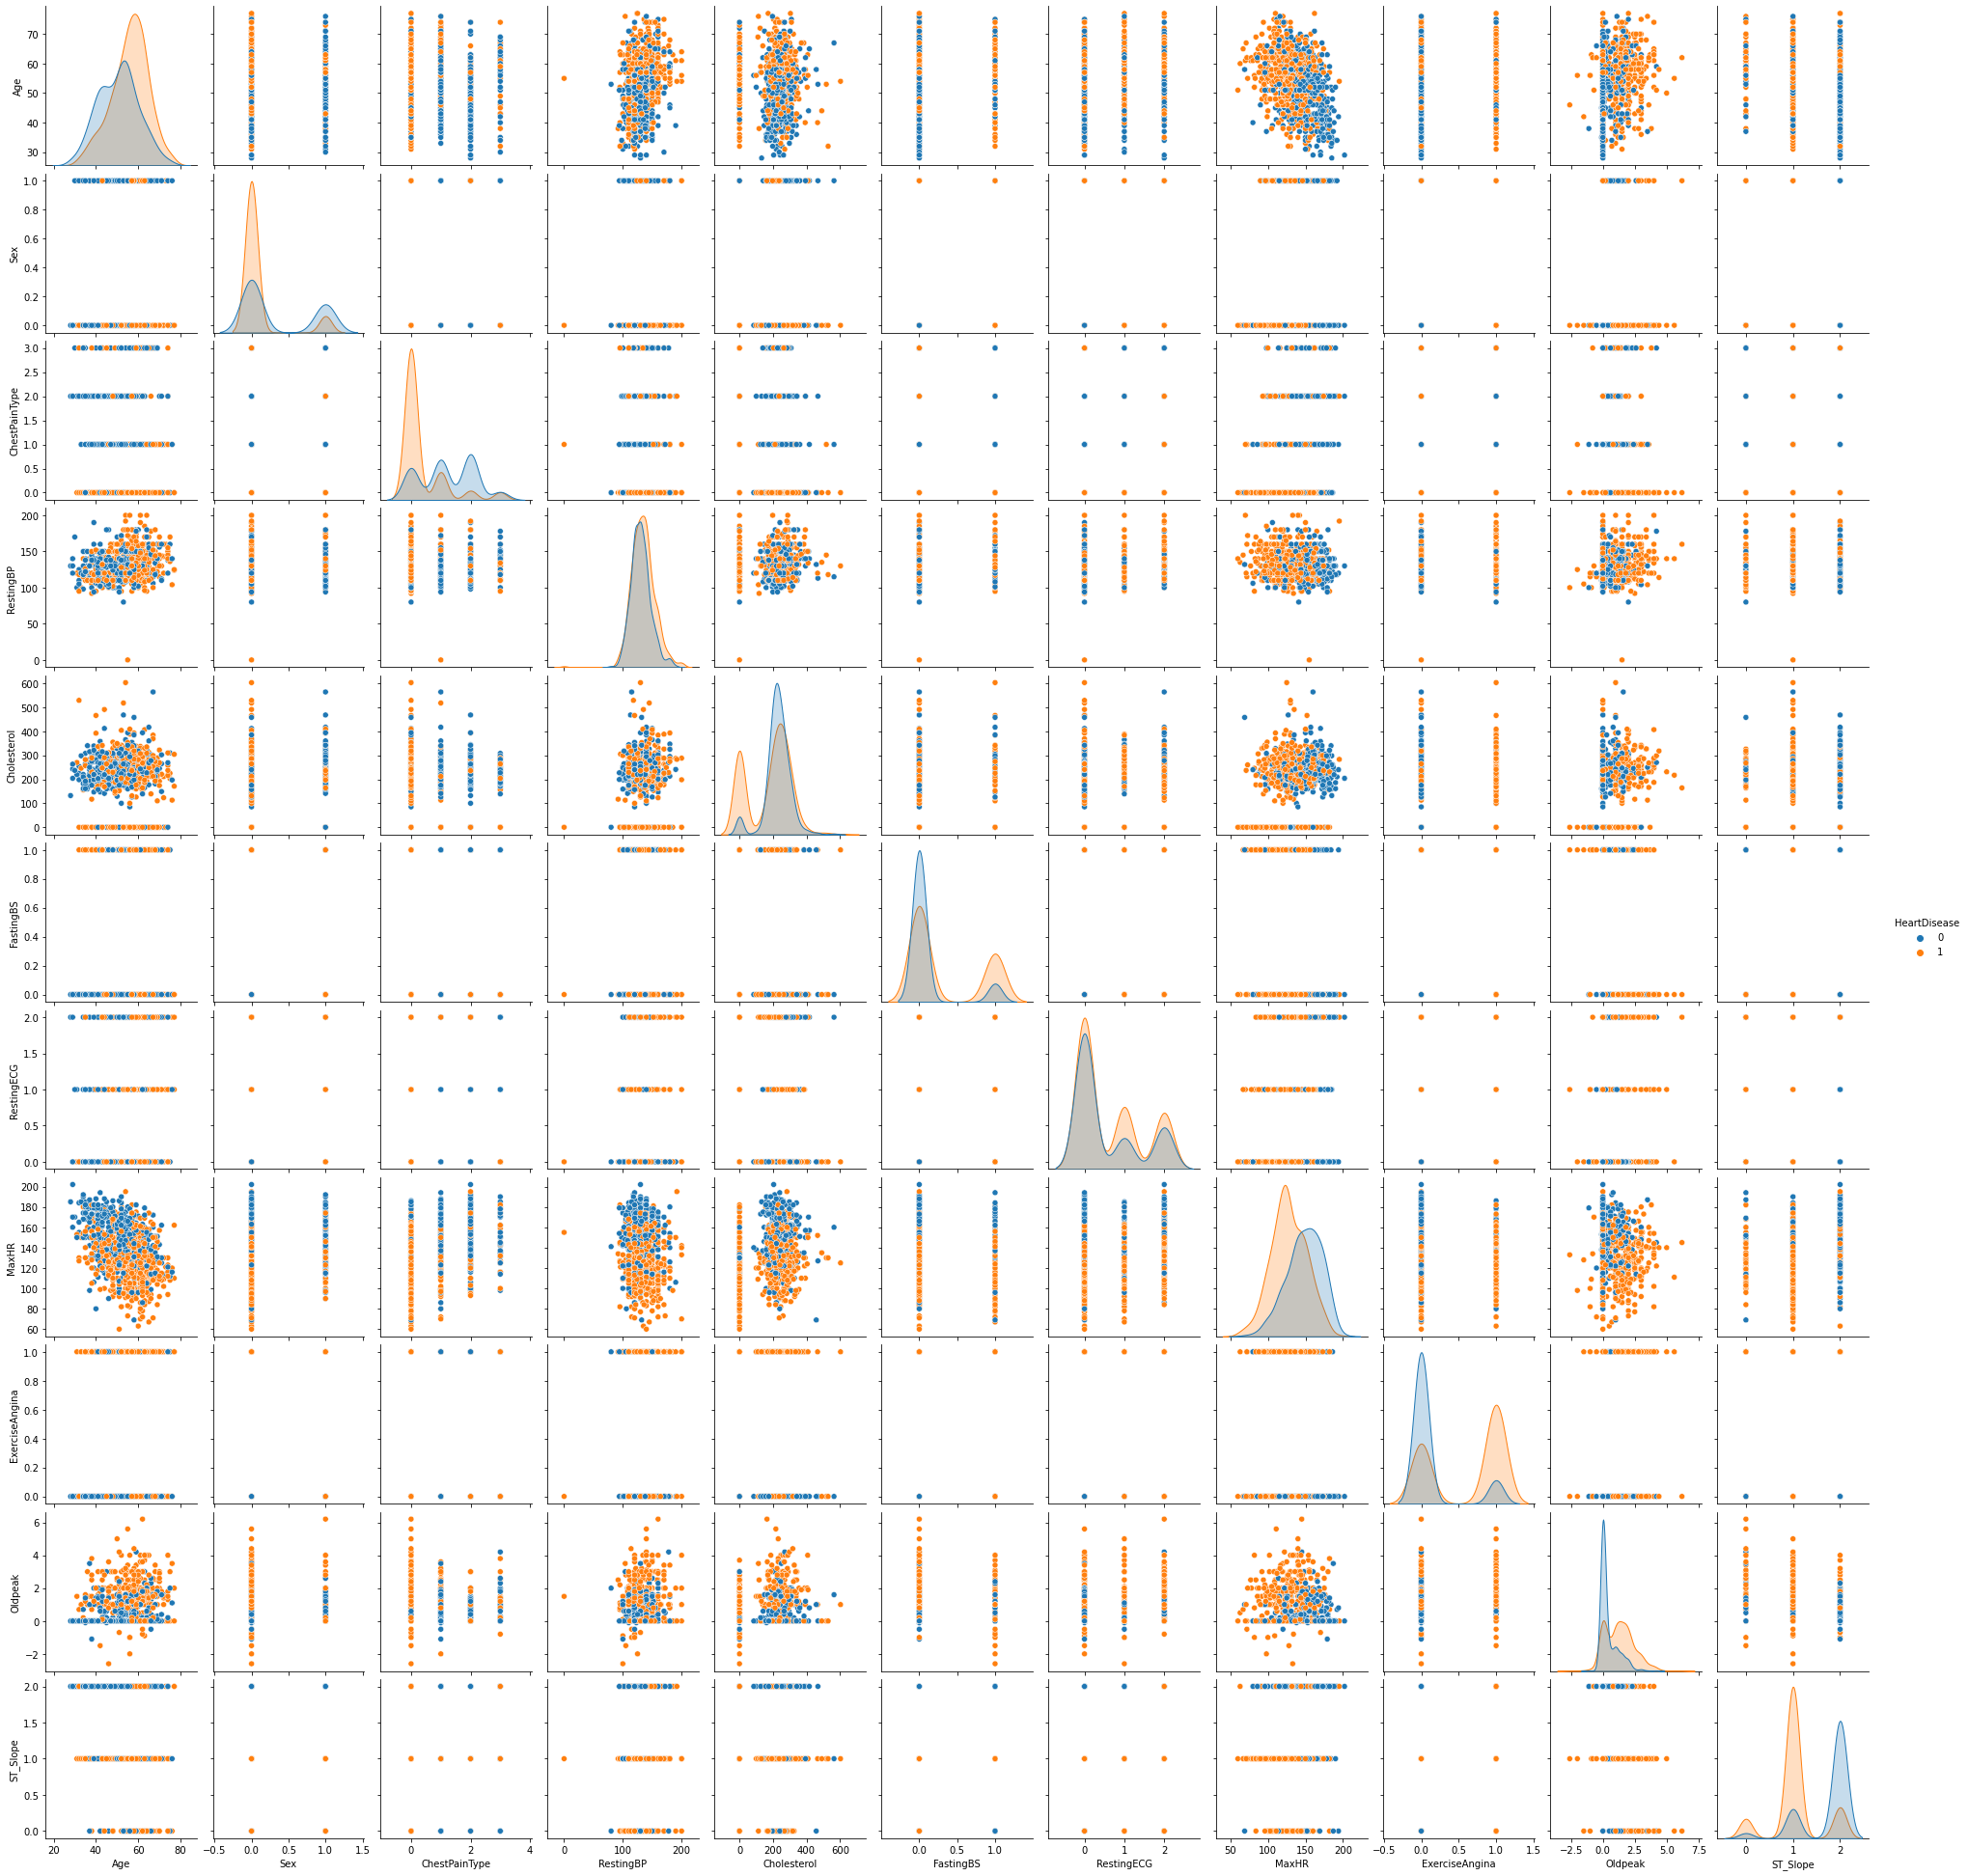

In [10]:
sns.pairplot(df, hue='HeartDisease')

Now we want to see the correlation between each numerical features

<AxesSubplot:>

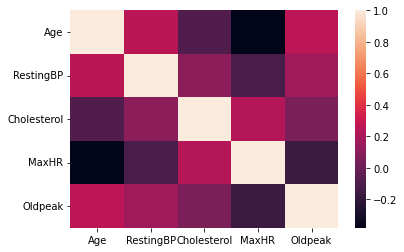

In [11]:
sns.heatmap(df[num_cols].corr())

As shown above, the correlation between each features are not high, so we don't have to worry about multicollinearity.

In [12]:
def num_plot(df, col):
    fig = px.histogram(df, x=col, color="HeartDisease",
                       marginal="box")
    fig.update_layout(height=400, width=500, showlegend=True)
    fig.update_traces(marker_line_width=1,marker_line_color="black")
    fig.show()

More detail about numerical features are shown below :

In [13]:
for col in num_cols:
    num_plot(df, col)

# Preporcessing
-------------

# Model Building
---------------------

# Model Training
-----------------

# Model Testing 
-----------------

# Comparison Among Different Methods
------------